In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from init_objects import *
from functions.helpers import organise_data, hypothetical_series, get_specific_bootstraps_moments
from functions.inequality import gini
from distribution_model import *
import statsmodels.api as sm
from matplotlib import style
import scipy.stats as stats
from functions.evolutionaryalgo import *

In [2]:
style.use('ggplot')

# Volatility inequality model

In [3]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())

In [75]:
params['strat_share_chartists'] = 0.0
params['mutation_intensity'] = 0.0
params['average_learning_ability'] = 0.0
params['ticks'] = 400

In [76]:
params

{'ticks': 400,
 'fundamental_value': 166,
 'n_traders': 500,
 'std_fundamental': 20.0,
 'spread_max': 0.004087,
 'init_stocks': 50,
 'trader_sample_size': 19,
 'horizon': 100,
 'trades_per_tick': 3,
 'std_noise': 0.15863974,
 'w_random': 0.056454,
 'strat_share_chartists': 0.0,
 'base_risk_aversion': 6.05054016,
 'fundamentalist_horizon_multiplier': 2.22042767,
 'mutation_intensity': 0.0,
 'average_learning_ability': 0.0}

In [77]:
NRUNS = 2

In [92]:
stdev_fun = [x / 100.0 for x in range(0, 20000, 2000)]

In [93]:
stdev_fun[0] = 0.0001

In [94]:
stdev_fun

[0.0001, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0]

In [95]:
experiments = len(stdev_fun)

In [96]:
trdrs = []
orbs = []
for exp in range(experiments):
    params['std_fundamental'] = stdev_fun[exp]
    for seed in range(NRUNS): 
        traders, orderbook = init_objects_distr(params, seed)
        #traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
        traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
        trdrs.append(traders)
        orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  0
Start of simulation  1
Start of simulation  0
Start of simulation  1
Start of simulation  0
Start of simulation  1
Start of simulation  0
Start of simulation  1
Start of simulation  0
Start of simulation  1
Start of simulation  0
Start of simulation  1
Start of simulation  0
Start of simulation  1
Start of simulation  0
Start of simulation  1
Start of simulation  0
Start of simulation  1


In [97]:
full_stdev_fun = []
for exp in range(experiments):
    for seed in range(NRUNS):
        full_stdev_fun.append(stdev_fun[exp])

In [98]:
ginis = []
palmas = []

for idx, traders in enumerate(trdrs):
    money = np.array([x.var.money[-1] for x in trdrs[idx]])
    stocks = np.array([x.var.stocks[-1] for x in trdrs[idx]])
    wealth = money + (stocks * orbs[idx].tick_close_price[-1])
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palmas.append(share_top_10 / share_bottom_40)
    
    ginis.append(gini(wealth))

In [99]:
# calc redistribution, profits ... abs 
profits = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))

In [100]:
# split the data in parts of 10 
gini_averages = []
gini_conf_interval_uppers = []
gini_conf_intervals_lowers = []

palma_averages = []
palma_conf_interval_uppers = []
palma_conf_intervals_lowers = []

for x in range(experiments):
    y = x*NRUNS
    g = ginis[y:y+NRUNS]
    
    gini_averages.append(np.mean(g))
    sample_stdev = np.std(g)
    sigma = sample_stdev/math.sqrt(len(g))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(g), scale = sigma) 
    #lower, upper = confidence_interval(g, np.median(g))
    gini_conf_interval_uppers.append(min(upper, 1.0))
    gini_conf_intervals_lowers.append(lower)
    
    p = np.array(palmas[y:y+10])
    palma_averages.append(np.mean(p))
    #lower, upper = confidence_interval(p, np.median(p))
    sample_stdev = np.std(p)
    sigma = sample_stdev/math.sqrt(len(p))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p), scale = sigma) 
    palma_conf_interval_uppers.append(upper)
    palma_conf_intervals_lowers.append(max(lower, 0))

In [101]:
palma_averages

[1.787727742496866,
 2.1927634592232033,
 2.4623978316263972,
 2.7119259637931483,
 3.033223974798992,
 3.319682269040585,
 3.4567530307083585,
 3.6292519205832776,
 3.8760504936808537,
 4.024118352374739]

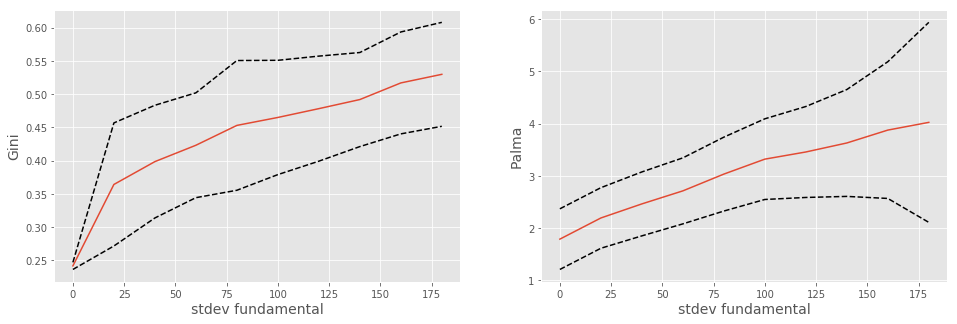

In [102]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,5])

ax1.plot(stdev_fun, gini_averages)
ax1.plot(stdev_fun, gini_conf_interval_uppers, 'k--')
ax1.plot(stdev_fun, gini_conf_intervals_lowers, 'k--')

ax2.plot(stdev_fun, palma_averages)
ax2.plot(stdev_fun, palma_conf_interval_uppers, 'k--')
ax2.plot(stdev_fun, palma_conf_intervals_lowers, 'k--')

ax1.set_ylabel('Gini', fontsize=14)
ax2.set_ylabel('Palma', fontsize=14)

for ax in [ax1, ax2]:
    ax.set_xlabel('stdev fundamental', fontsize=14)

fig.savefig('stdev_f_inequality.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)